## Opsætning

In [1]:
import spacy

In [2]:
# !python3 -m spacy download da_core_news_lg

In [4]:
nlp = spacy.load('da_core_news_lg')
nlp.max_length = 1200000

# Indlæsning af tekstfiler

In [5]:
def read_file(filepath):
  with open(filepath) as f:
    str_text = f.read()

    return str_text

In [6]:
def separate_punc(doc_text):
    return [token.text.lower() for token in nlp(doc_text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n ']

In [7]:
saga1 = '/Users/au648304/Documents/Tekster/ErikDenRødesSaga.txt'
saga2 = '/Users/au648304/Documents/Tekster/EyrbyggjaSaga.txt'
saga3 = '/Users/au648304/Documents/Tekster/FæringernesSaga.txt'
saga4 = '/Users/au648304/Documents/Tekster/GrønlændernesSaga.txt'

combinedSaga = read_file(saga1) + read_file(saga2) + read_file(saga3) + read_file(saga4)

In [8]:
tokens = separate_punc(combinedSaga)

In [9]:
len(tokens)

64997

# Klargør teksten til modellen

In [10]:
from keras.preprocessing.text import Tokenizer

In [11]:
# 25 træningsord og 1 feature ord
train_len = 25+1

text_sequences = []

for i in range(train_len, len(tokens)):

    seq = tokens[i-train_len:i]

    text_sequences.append(seq)

In [12]:
len(text_sequences)

64971

In [13]:
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

In [ ]:
# tokenizer.index_word

In [ ]:
# tokenizer.word_counts

In [14]:
vocabulary_size = len(tokenizer.word_counts)

In [15]:
vocabulary_size

6370

## Klargør X og Y ud fra sekvenserne

In [16]:
import numpy as np
from keras.utils import to_categorical

In [17]:
sequences = np.array(sequences)

In [18]:
# De første 25 kolonner og dermed ord.
X = sequences[:, :-1]

# Den sidste kolonne og dermed det sidste ord.
y = sequences[:,-1]
y = to_categorical(y, num_classes=vocabulary_size+1)

In [19]:
seq_len = X.shape[1]

In [20]:
seq_len

25

# Skab modellen

In [28]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding
from pickle import dump, load

In [22]:
def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, seq_len, input_length=seq_len))
    model.add(LSTM(2*seq_len, return_sequences=True))
    model.add(LSTM(2*seq_len))
    model.add(Dense(2*seq_len, activation='relu'))

    model.add(Dense(vocabulary_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model

In [23]:
model = create_model(vocabulary_size+1, seq_len)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 25)            159275    
                                                                 
 lstm (LSTM)                 (None, 25, 50)            15200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 6371)              324921    
                                                                 
Total params: 522146 (1.99 MB)
Trainable params: 522146 (1.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
# fit model
history = model.fit(X, y, batch_size=128, epochs=100,verbose=1, validation_data=(X,y))

model.save('/Users/au648304/Documents/TextGeneration/saga_100epoch.h5')
dump(tokenizer, open('/Users/au648304/Documents/TextGeneration/saga_100epoch', 'wb'))
dump(history.history['accuracy'], open('/Users/au648304/Documents/TextGeneration/saga_100epoch_history_accuracy', 'wb'))
dump(history.history['val_accuracy'], open('/Users/au648304/Documents/TextGeneration/saga_100epoch_history_valaccuracy', 'wb'))

Epoch 1/100
508/508 [==============================] - 29s 58ms/step - loss: 5.8137 - accuracy: 0.0826 - val_loss: 5.6880 - val_accuracy: 0.0858
Epoch 2/100
508/508 [==============================] - 28s 55ms/step - loss: 5.7045 - accuracy: 0.0869 - val_loss: 5.5965 - val_accuracy: 0.0903
Epoch 3/100
508/508 [==============================] - 28s 55ms/step - loss: 5.5977 - accuracy: 0.0918 - val_loss: 5.4665 - val_accuracy: 0.0988
Epoch 4/100
508/508 [==============================] - 29s 58ms/step - loss: 5.4946 - accuracy: 0.0976 - val_loss: 5.3685 - val_accuracy: 0.1022
Epoch 5/100
508/508 [==============================] - 29s 56ms/step - loss: 5.3976 - accuracy: 0.1026 - val_loss: 5.2768 - val_accuracy: 0.1056
Epoch 6/100
508/508 [==============================] - 29s 56ms/step - loss: 5.3105 - accuracy: 0.1065 - val_loss: 5.1918 - val_accuracy: 0.1081
Epoch 7/100
508/508 [==============================] - 32s 63ms/step - loss: 5.2330 - accuracy: 0.1095 - val_loss: 5.1063 - val_ac

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


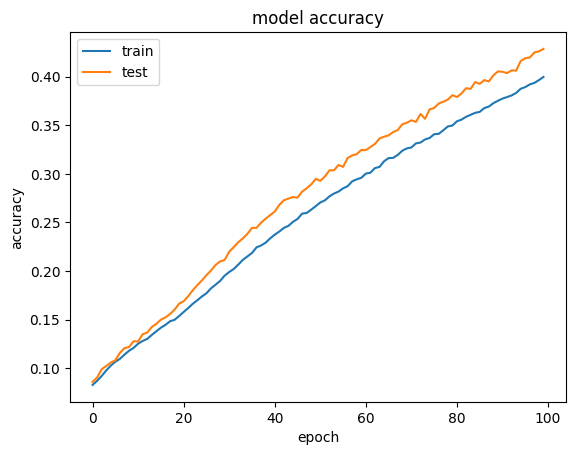

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
history_accuracy = load(open('/Users/au648304/Documents/TextGeneration/saga_100epoch_history_accuracy','rb'))
history_accuracy2 = load(open('/Users/au648304/Documents/TextGeneration/saga_100epoch_history_accuracy','rb'))
tmp = history_accuracy + history_accuracy2
type(tmp)

list

In [47]:
model = load_model('/Users/au648304/Documents/TextGeneration/saga_100epoch.h5')
tokenizer = load(open('/Users/au648304/Documents/TextGeneration/saga_100epoch','rb'))
history_accuracy = load(open('/Users/au648304/Documents/TextGeneration/saga_100epoch_history_accuracy','rb'))
history_valaccuracy = load(open('/Users/au648304/Documents/TextGeneration/saga_100epoch_history_valaccuracy','rb'))

history = model.fit(X, y, batch_size=128, epochs=100,verbose=1, validation_data=(X,y))

accuracy = history_accuracy + history.history['accuracy']
valaccuracy = history_valaccuracy + history.history['val_accuracy']

model.save('/Users/au648304/Documents/TextGeneration/saga_200epoch.h5')
dump(tokenizer, open('/Users/au648304/Documents/TextGeneration/saga_200epoch', 'wb'))
dump(accuracy, open('/Users/au648304/Documents/TextGeneration/saga_200epoch_history_accuracy', 'wb'))
dump(valaccuracy, open('/Users/au648304/Documents/TextGeneration/saga_200epoch_history_valaccuracy', 'wb'))

Epoch 1/100
508/508 [==============================] - 34s 63ms/step - loss: 2.6221 - accuracy: 0.4014 - val_loss: 2.4914 - val_accuracy: 0.4271
Epoch 2/100
508/508 [==============================] - 30s 58ms/step - loss: 2.6137 - accuracy: 0.4023 - val_loss: 2.4717 - val_accuracy: 0.4302
Epoch 3/100
508/508 [==============================] - 31s 60ms/step - loss: 2.5992 - accuracy: 0.4055 - val_loss: 2.4742 - val_accuracy: 0.4315
Epoch 4/100
508/508 [==============================] - 28s 55ms/step - loss: 2.5915 - accuracy: 0.4061 - val_loss: 2.4392 - val_accuracy: 0.4375
Epoch 5/100
508/508 [==============================] - 32s 63ms/step - loss: 2.5778 - accuracy: 0.4083 - val_loss: 2.4466 - val_accuracy: 0.4359
Epoch 6/100
508/508 [==============================] - 28s 56ms/step - loss: 2.5625 - accuracy: 0.4133 - val_loss: 2.4288 - val_accuracy: 0.4403
Epoch 7/100
508/508 [==============================] - 28s 56ms/step - loss: 2.5473 - accuracy: 0.4134 - val_loss: 2.4242 - val_ac

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


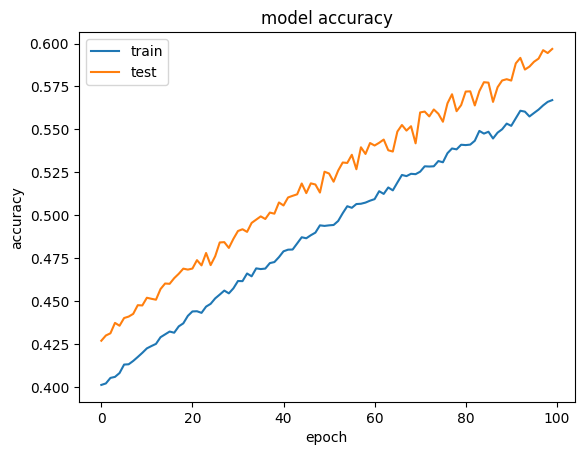

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
model = load_model('/Users/au648304/Documents/TextGeneration/saga_200epoch.h5')
tokenizer = load(open('/Users/au648304/Documents/TextGeneration/saga_200epoch','rb'))
history_accuracy = load(open('/Users/au648304/Documents/TextGeneration/saga_200epoch_history_accuracy','rb'))
history_valaccuracy = load(open('/Users/au648304/Documents/TextGeneration/saga_200epoch_history_valaccuracy','rb'))

history = model.fit(X, y, batch_size=128, epochs=100,verbose=1, validation_data=(X,y))

accuracy = history_accuracy + history.history['accuracy']
valaccuracy = history_valaccuracy + history.history['val_accuracy']

model.save('/Users/au648304/Documents/TextGeneration/saga_300epoch.h5')
dump(tokenizer, open('/Users/au648304/Documents/TextGeneration/saga_300epoch', 'wb'))
dump(accuracy, open('/Users/au648304/Documents/TextGeneration/saga_300epoch_history_accuracy', 'wb'))
dump(valaccuracy, open('/Users/au648304/Documents/TextGeneration/saga_300epoch_history_valaccuracy', 'wb'))

Epoch 1/100
508/508 [==============================] - 32s 60ms/step - loss: 1.7937 - accuracy: 0.5641 - val_loss: 1.6559 - val_accuracy: 0.5982
Epoch 2/100
508/508 [==============================] - 30s 58ms/step - loss: 1.7755 - accuracy: 0.5703 - val_loss: 1.6602 - val_accuracy: 0.5980
Epoch 3/100
508/508 [==============================] - 31s 62ms/step - loss: 1.7708 - accuracy: 0.5687 - val_loss: 1.6611 - val_accuracy: 0.5993
Epoch 4/100
508/508 [==============================] - 29s 56ms/step - loss: 1.7786 - accuracy: 0.5679 - val_loss: 1.6508 - val_accuracy: 0.5998
Epoch 5/100
508/508 [==============================] - 29s 57ms/step - loss: 1.7609 - accuracy: 0.5716 - val_loss: 1.6312 - val_accuracy: 0.6061
Epoch 6/100
508/508 [==============================] - 29s 57ms/step - loss: 1.7444 - accuracy: 0.5756 - val_loss: 1.6257 - val_accuracy: 0.6064
Epoch 7/100
508/508 [==============================] - 29s 57ms/step - loss: 1.7454 - accuracy: 0.5775 - val_loss: 1.6413 - val_ac

In [50]:
model = load_model('/Users/au648304/Documents/TextGeneration/saga_300epoch.h5')
tokenizer = load(open('/Users/au648304/Documents/TextGeneration/saga_300epoch','rb'))
history_accuracy = load(open('/Users/au648304/Documents/TextGeneration/saga_300epoch_history_accuracy','rb'))
history_valaccuracy = load(open('/Users/au648304/Documents/TextGeneration/saga_300epoch_history_valaccuracy','rb'))

history = model.fit(X, y, batch_size=128, epochs=100,verbose=1, validation_data=(X,y))

accuracy = history_accuracy + history.history['accuracy']
valaccuracy = history_valaccuracy + history.history['val_accuracy']

model.save('/Users/au648304/Documents/TextGeneration/saga_400epoch.h5')
dump(tokenizer, open('/Users/au648304/Documents/TextGeneration/saga_400epoch', 'wb'))
dump(accuracy, open('/Users/au648304/Documents/TextGeneration/saga_400epoch_history_accuracy', 'wb'))
dump(valaccuracy, open('/Users/au648304/Documents/TextGeneration/saga_400epoch_history_valaccuracy', 'wb'))

Epoch 1/100
508/508 [==============================] - 33s 62ms/step - loss: 1.3594 - accuracy: 0.6598 - val_loss: 1.2693 - val_accuracy: 0.6845
Epoch 2/100
508/508 [==============================] - 32s 63ms/step - loss: 1.3566 - accuracy: 0.6611 - val_loss: 1.2666 - val_accuracy: 0.6861
Epoch 3/100
508/508 [==============================] - 30s 59ms/step - loss: 1.3416 - accuracy: 0.6642 - val_loss: 1.2793 - val_accuracy: 0.6803
Epoch 4/100
508/508 [==============================] - 31s 60ms/step - loss: 1.3151 - accuracy: 0.6718 - val_loss: 1.2327 - val_accuracy: 0.6935
Epoch 5/100
508/508 [==============================] - 30s 59ms/step - loss: 1.3329 - accuracy: 0.6664 - val_loss: 1.2344 - val_accuracy: 0.6938
Epoch 6/100
508/508 [==============================] - 29s 58ms/step - loss: 1.3408 - accuracy: 0.6659 - val_loss: 1.2028 - val_accuracy: 0.7038
Epoch 7/100
508/508 [==============================] - 27s 54ms/step - loss: 1.3204 - accuracy: 0.6691 - val_loss: 1.2587 - val_ac

In [36]:
dump(history.history['accuracy'], open('/Users/au648304/Documents/TextGeneration/saga_2epoch_3_history_accuracy', 'wb'))
dump(history.history['val_accuracy'], open('/Users/au648304/Documents/TextGeneration/saga_2epoch_3_history_valaccuracy', 'wb'))

In [37]:
history_accuracy2 = load(open('/Users/au648304/Documents/TextGeneration/saga_2epoch_3_history_accuracy','rb'))
history_valaccuracy2 = load(open('/Users/au648304/Documents/TextGeneration/saga_2epoch_3_history_valaccuracy','rb'))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


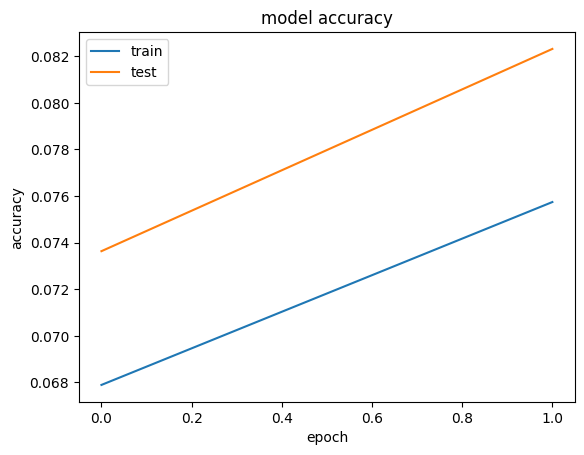

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history_accuracy2)
plt.plot(history_valaccuracy2)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Gem modellen

In [ ]:
from pickle import dump, load

In [ ]:
model.save('/content/sample_data/saga_10epoch_2.h5')
# save the tokenizer
dump(tokenizer, open('/content/sample_data/saga_10epoch_2', 'wb'))

# Generer ny tekst
## Modellen er trænet på 10 epochs

In [ ]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.utils import pad_sequences

In [ ]:
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    '''
    INPUTS:
    model : model that was trained on text data
    tokenizer : tokenizer that was fit on text data
    seq_len : length of training sequence
    seed_text : raw string text to serve as the seed
    num_gen_words : number of words to be generated by model
    '''

    # Final Output
    output_text = []

    # Intial Seed Sequence
    input_text = seed_text

    # Create num_gen_words
    for i in range(num_gen_words):

        # Take the input text string and encode it to a sequence
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]

        # Pad sequences to our trained rate (50 words in the video)
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')

        # Predict Class Probabilities for each word
        predict = model.predict(pad_encoded, verbose=0)[0]
        pred_word_ind = predict.argmax()
        # pred_word_ind = model.predict_classes(pad_encoded, verbose=0)[0]

        # Grab word
        pred_word = tokenizer.index_word[pred_word_ind]

        # Update the sequence of input text (shifting one over with the new word)
        input_text += ' ' + pred_word

        output_text.append(pred_word)

    # Make it look like a sentence.
    return ' '.join(output_text)

In [ ]:
import random
random.seed(101)
random_pick = random.randint(0,len(text_sequences))
random_seed_text = text_sequences[random_pick]
seed_text = ' '.join(random_seed_text)
seed_text

'han var en dygtig bonde og havde en stor ejendom han var snu mand og morbror til trond i gøta færingernes tingsted lå på strømø hvor'

In [ ]:
model = load_model('/content/sample_data/saga_10epoch.h5')
tokenizer = load(open('/content/sample_data/saga_10epoch','rb'))

generate_text(model, tokenizer, seq_len, seed_text, num_gen_words=25)

'han var en mand og de var en mand og var en mand og de var en mand og var en mand og de var'

In [ ]:
model.evaluate(X, y)

2031/2031 [==============================] - 33s 16ms/step - loss: 5.3582 - accuracy: 0.1080


[5.358155727386475, 0.10803281515836716]

# Træn den på 300 epochs

In [101]:
# fit model
model.fit(X, y, batch_size=256, epochs=300,verbose=1)

model.save('/content/sample_data/saga_300epoch.h5')
# save the tokenizer
dump(tokenizer, open('/content/sample_data/saga_300epoch', 'wb'))

Epoch 1/300
254/254 [==============================] - 50s 187ms/step - loss: 5.3900 - accuracy: 0.1070
Epoch 2/300
254/254 [==============================] - 40s 157ms/step - loss: 5.3280 - accuracy: 0.1096
Epoch 3/300
254/254 [==============================] - 41s 162ms/step - loss: 5.2651 - accuracy: 0.1128
Epoch 4/300
254/254 [==============================] - 41s 161ms/step - loss: 5.2045 - accuracy: 0.1169
Epoch 5/300
254/254 [==============================] - 40s 155ms/step - loss: 5.1453 - accuracy: 0.1180
Epoch 6/300
254/254 [==============================] - 41s 162ms/step - loss: 5.0861 - accuracy: 0.1221
Epoch 7/300
254/254 [==============================] - 41s 162ms/step - loss: 5.0294 - accuracy: 0.1247
Epoch 8/300
254/254 [==============================] - 42s 164ms/step - loss: 4.9762 - accuracy: 0.1261
Epoch 9/300
254/254 [==============================] - 42s 164ms/step - loss: 4.9204 - accuracy: 0.1286
Epoch 10/300
254/254 [==============================] - 40s 156m

In [1]:
model.summarize

NameError: ignored